# Implementing a decision tree

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Import models from scikit learn module
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [6]:
df = pd.read_csv('Data/car.data', names = ['buying', 'maint', 'doors',
                                                'persons', 'lug_boot', 'safety', 'accep'])
df.head()

,buying,maint,doors,persons,lug_boot,safety,accep
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


`cars.data` features;
- `buying` - price of the car
- `maint` - cost of maintaining the car
- `doors` - number of doors
- `persons` - number of people the car can hold
- `lugboot` - size of the boot
- `safety` - safety rating of the car

##### Question

"When considering buying a car, what factors go into making that decision?"

In [7]:
## Setting the target and predictor variables
df['accep'] = ~(df['accep']=='unacc') #1 is acceptable, 0 if not acceptable

# Create dummy features for the categorical values
X = pd.get_dummies(df.iloc[:,0:6])
y = df['accep']

print(F"Predictor variables:\n\n{X.columns}\n")
print(F"Number of features: {len(X.columns)}")

Predictor variables:

Index(['buying_high', 'buying_low', 'buying_med', 'buying_vhigh', 'maint_high',
       'maint_low', 'maint_med', 'maint_vhigh', 'doors_2', 'doors_3',
       'doors_4', 'doors_5more', 'persons_2', 'persons_4', 'persons_more',
       'lug_boot_big', 'lug_boot_med', 'lug_boot_small', 'safety_high',
       'safety_low', 'safety_med'],
      dtype='object')

Number of features: 21


In [8]:
## Performing the train-test split
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

## Fitting the decision tree classifier
dt = DecisionTreeClassifier(max_depth=3, ccp_alpha=0.01,criterion='gini')
dt.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.01, max_depth=3)

### Plotting the decision tree

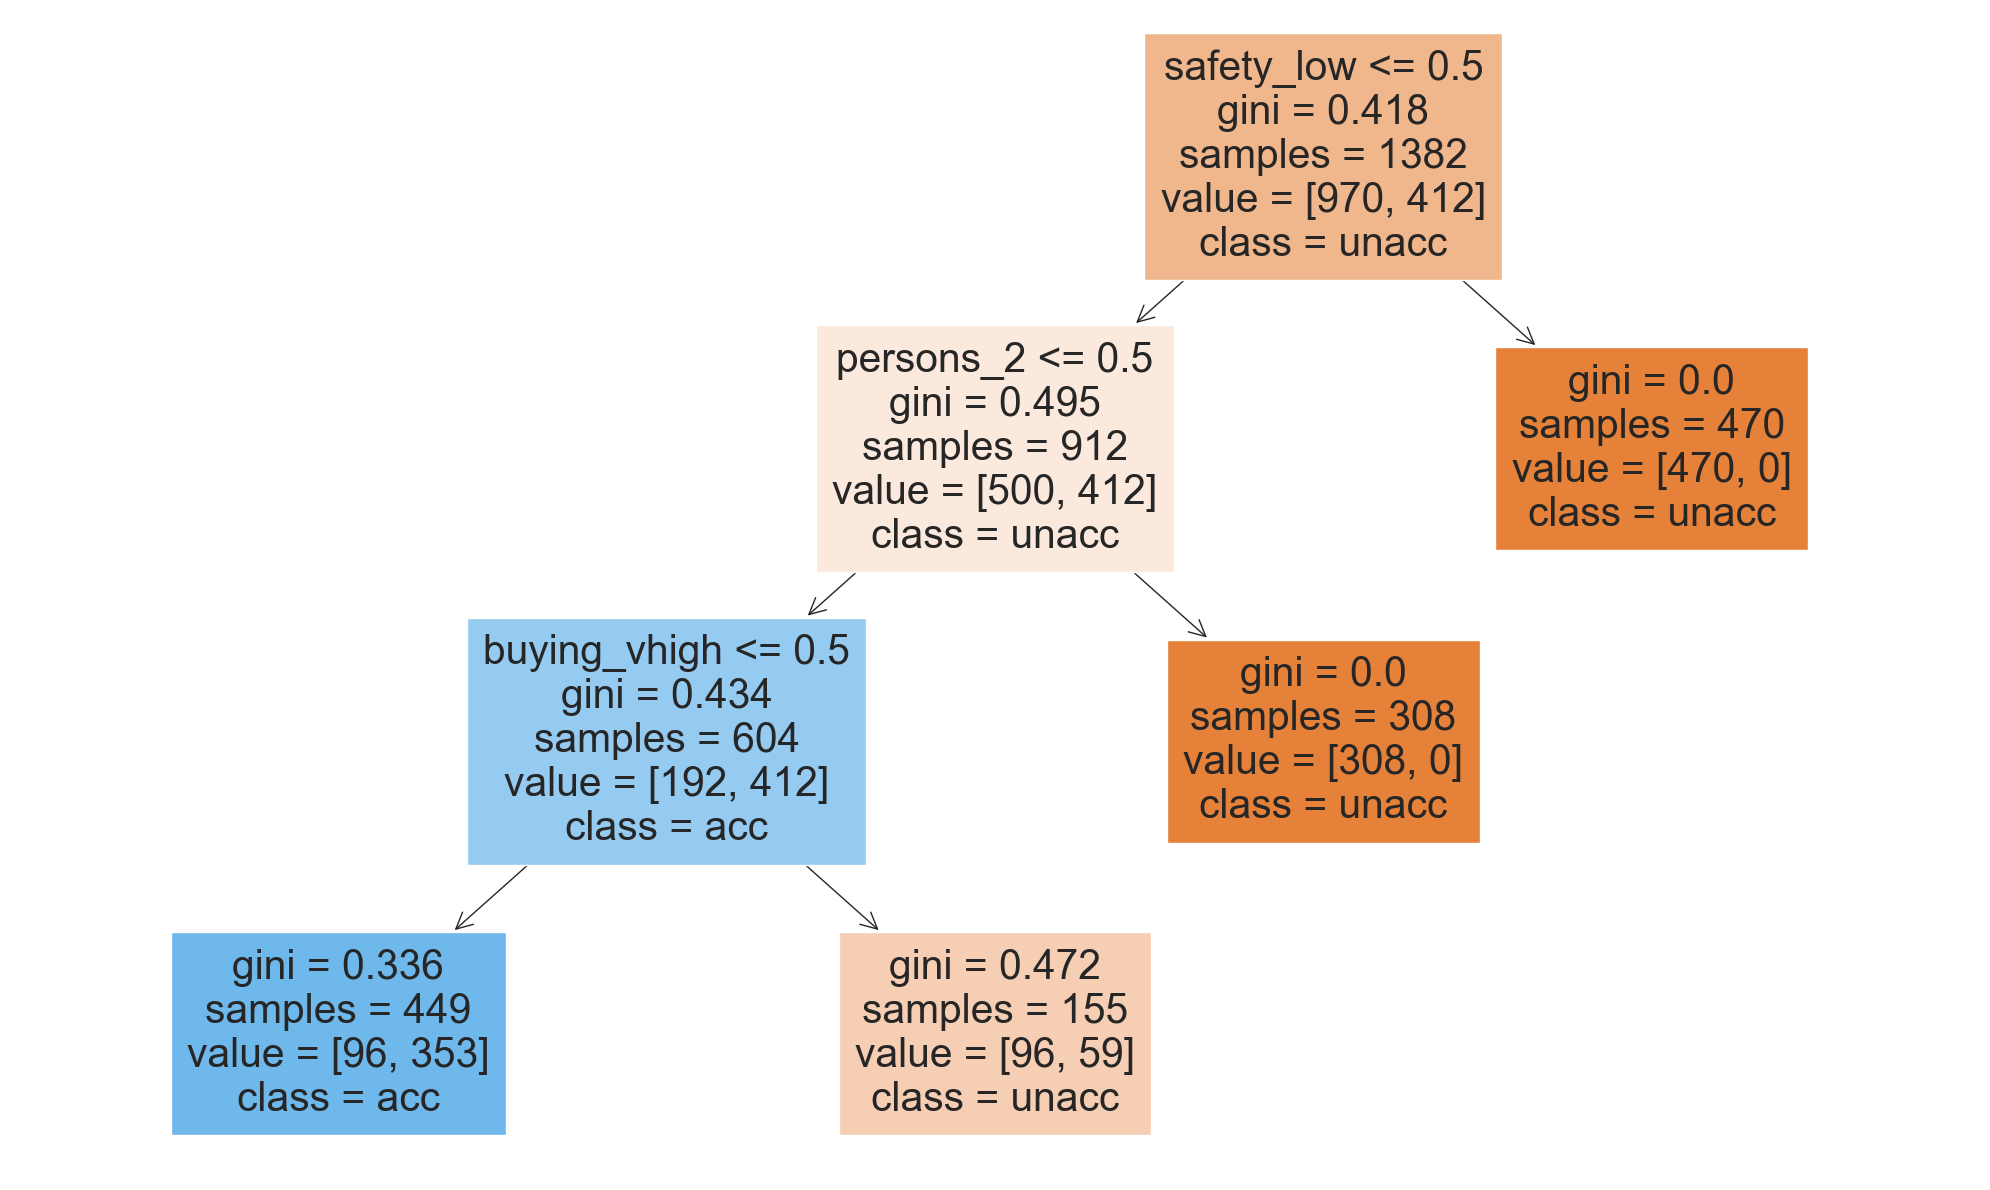

In [9]:
plt.figure(figsize=(20,12))
tree.plot_tree(dt, feature_names = x_train.columns, max_depth=5, class_names = ['unacc', 'acc'], label='all', filled=True)
plt.tight_layout()
plt.show()

#### Interpretation

1. The "root node" is the top of the tree
&nbsp;
2. Splits occur with True to left, False to right
The right split is a `leaf node` (there are no more branches) - Decision ending here results in the majority class

In [10]:
frac_acc = 412/1382
print(f'Fraction of acceptable cars: {frac_acc}')

Fraction of acceptable cars: 0.2981186685962373


`safety_low <=0.5` is a dummy variable, 1 = `safety='low'`, 0 = `safety<>'low'`

In [11]:
low_safety_class = 'unacc'
print(f'Cars with low safety: {low_safety_class}')

Cars with low safety: unacc


 Final outcome of the decision tree for the sample with;
 `buying_vhigh`= 1, `persons_2`= 0, `safety_low`= 0.

In [12]:
sample_class = 'unacc'
print(f'The class of the sample car: {sample_class}')

The class of the sample car: unacc


----

## Gini Impurity

If we have $C$ total classes and $p_i$ is the probability of picking a datapoint with class $I$, then the Gini impurity is;

$$Gini=1-\sum_{i=1}^C(p_i)^{2}$$

#### For the root node,
&nbsp;
<img src="/Users/Ian/Desktop/Study/ComputerScience/Codecademy/Github Page/ML-Fundamentals/Supervised Learning/6 - Decision Trees/Images/root node.jpg"/>
&nbsp;
$Gini = 1-((412/1382)^{2}+(970/1382)^{2})$

In [13]:
gini = 1 - ((412/1382)**2+(970/1382)**2)
print(F"The Gini impurity: {gini}")

The Gini impurity: 0.41848785606128835


#### Bottom left node
&nbsp;
<img src="/Users/Ian/Desktop/Study/ComputerScience/Codecademy/Github Page/ML-Fundamentals/Supervised Learning/6 - Decision Trees/Images/Bottom left node.jpg"/>
&nbsp;
Gini = $1-((96/449)^2+(1-(96/449))^2)$

In [14]:
gini2 = 1-((96/449)**2+(1-(96/449))**2)
print(F"Gini impurity: {gini2}")

Gini impurity: 0.33618880858725886


----
&nbsp;
### Information Gain

We want to end up with leaves with a low Gini impurity

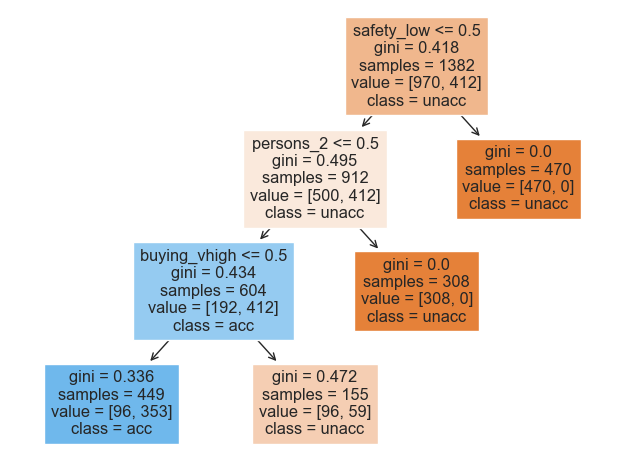

In [15]:
tree.plot_tree(dt, feature_names = x_train.columns, max_depth=5, class_names = ['unacc', 'acc'], label='all', filled=True)
plt.tight_layout()
plt.show()

In [16]:
#1. Information gain at a pure node (i.e., node with no more branches!)

r = 0.5 #ratio of new split, could be anything
gini_pure_node = 0
gini_info_gain = r*gini_pure_node  + (1-r)*gini_pure_node
print(f'Gini information gain pure node split safety_low >= .5 : {gini_info_gain}')

Gini information gain pure node split safety_low >= .5 : 0.0


In [17]:
#2. Information gain at the 'persons_2' split

r_persons_2 = 604/912 #read ratio of the split from the tree!
gini_left_split = 0.434
gini_right_split = 0.0
gini_info_gain_persons_2 = r_persons_2*gini_left_split + r_persons_2*gini_right_split
print(f'Gini information gain node persons_2 : {gini_info_gain_persons_2}')

Gini information gain node persons_2 : 0.2874298245614035


----
&nbsp;
## How a decision tree is built

Functions to calculate the Gini impurity and information gain

In [18]:
def gini(data):
    """calculate the Gini Impurity
    """
    data = pd.Series(data)
    return 1 - sum(data.value_counts(normalize=True)**2)

def info_gain(left, right, current_impurity):
    """Information Gain associated with creating a node/split data.
    Input: left, right are data in left branch, right banch, respectively
    current_impurity is the data impurity before splitting into left, right branches
    """
    # weight for gini score of the left branch
    w = float(len(left)) / (len(left) + len(right))
    return current_impurity - w * gini(left) - (1 - w) * gini(right)

In [19]:
## 1. Calculate gini and info gain for a root node split at safety_low<=0.5
y_train_sub = y_train[x_train['safety_low']==0]
x_train_sub = x_train[x_train['safety_low']==0]

gi = gini(y_train_sub)
print(f'Gini impurity at root: {gi}')

Gini impurity at root: 0.49534472145275465


In [20]:
## 2. Information gain when using feature `persons_2`
left = y_train[x_train['persons_2']==0]
right = y_train[x_train['persons_2']==1]

print(f'Information gain for persons_2: {info_gain(left, right, gi)}')

Information gain for persons_2: 0.16699155320608106


In [21]:
info_gain_list = []
for i in x_train.columns:
     left = y_train_sub[x_train_sub[i]==0]
     right = y_train_sub[x_train_sub[i]==1]
     info_gain_list.append([i, info_gain(left, right, gi)])

info_gain_table = pd.DataFrame(info_gain_list).sort_values(1,ascending=False)
print(f'Greatest impurity gain at:\n{info_gain_table.iloc[0,:]}')
info_gain_table

Greatest impurity gain at:
0    persons_2
1     0.208137
Name: 12, dtype: object


,0,1
12,persons_2,0.208137
14,persons_more,0.056305
13,persons_4,0.048902
7,maint_vhigh,0.027772
3,buying_vhigh,0.025267
17,lug_boot_small,0.015210
1,buying_low,0.014392
5,maint_low,0.009816
15,lug_boot_big,0.009160
6,maint_med,0.008975


### Recursive algorithm

Now that we can find the best feature to split the dataset, we can repeat this process again and again to create the full tree

----
&nbsp;
## Train and predict using `scikit-learn`

In [22]:
## 1. Create a decision tree and print the parameters
dtree = DecisionTreeClassifier()
print(f'Default decision Tree parameters:\n{dtree.get_params()}')

Default decision Tree parameters:
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


In [23]:
## 2. Fit decision tree on training set and print the depth of the tree
dtree.fit(x_train, y_train)
print(f'Decision tree depth: {dtree.get_depth()}')

Decision tree depth: 11


In [24]:
y_pred = dtree.predict(x_test)
print(f'Test set accuracy: {dtree.score(x_test, y_test)}') # or accuracy_score(y_test, y_pred)

Test set accuracy: 0.9884393063583815


----
&nbsp;
## Visualising Decision Trees

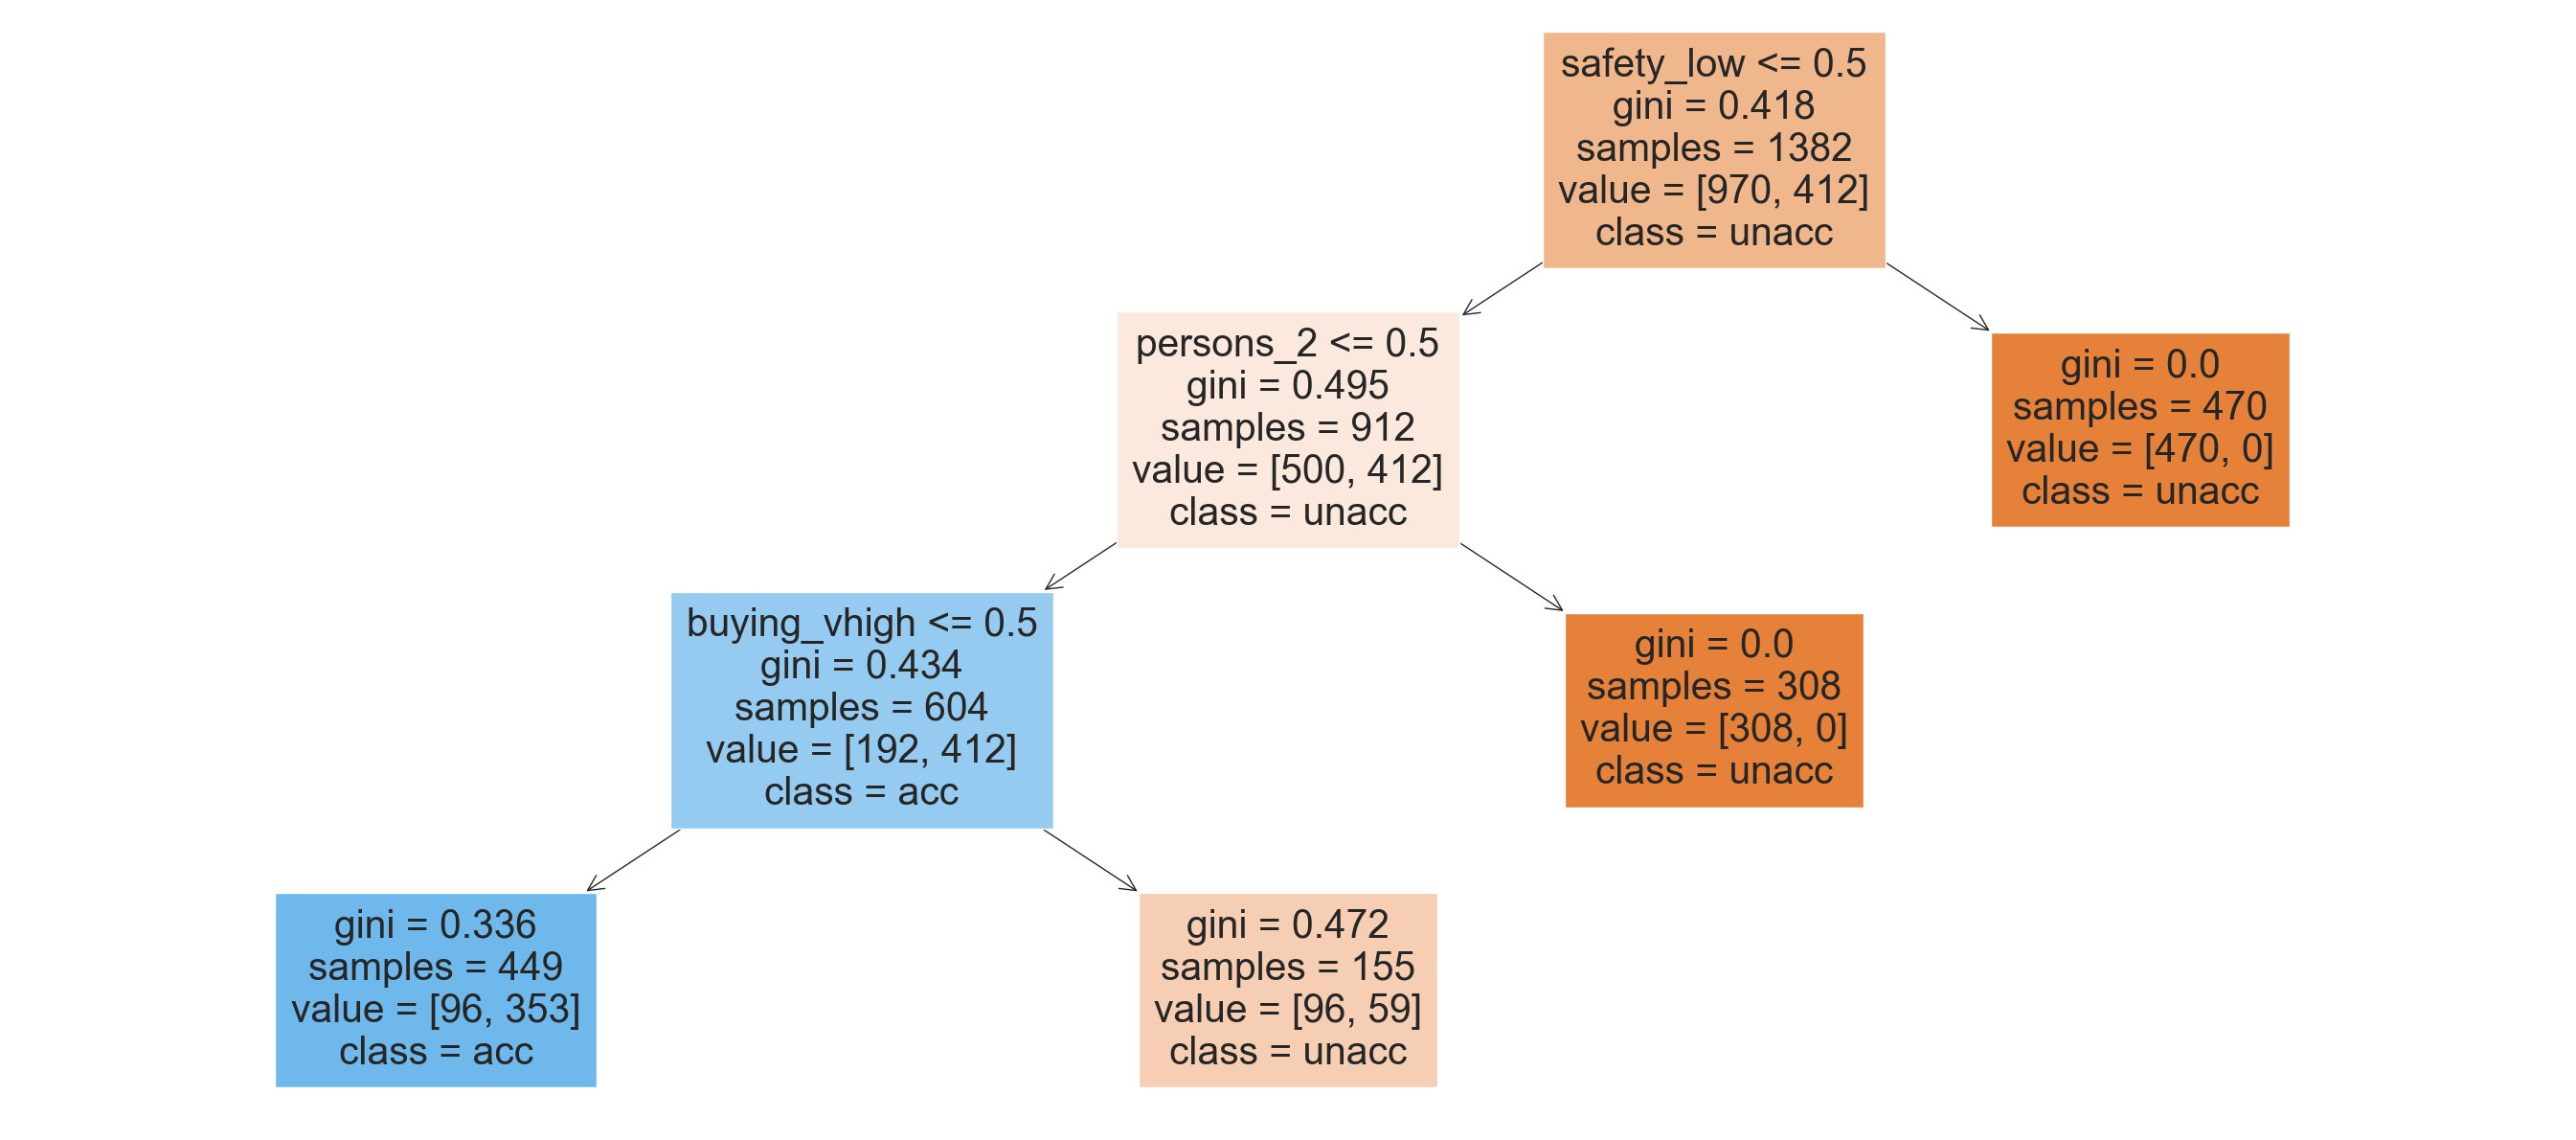

In [25]:
dtree = DecisionTreeClassifier(max_depth=3)
dtree.fit(x_train, y_train)

## Visualizing the tree
plt.figure(figsize=(27,12))
tree.plot_tree(dtree, feature_names = x_train.columns, class_names = ['unacc','acc'], filled=True)
plt.tight_layout()
plt.show()

In [26]:
## Text-based visualization of the tree
print(tree.export_text(dtree, feature_names = x_train.columns.to_list()))

|--- safety_low <= 0.50
|   |--- persons_2 <= 0.50
|   |   |--- buying_vhigh <= 0.50
|   |   |   |--- class: True
|   |   |--- buying_vhigh >  0.50
|   |   |   |--- class: False
|   |--- persons_2 >  0.50
|   |   |--- class: False
|--- safety_low >  0.50
|   |--- class: False



----
&nbsp;
## Larger Trees tend to overfit the data

In [27]:
## 1. Two decision trees
dtree1 = DecisionTreeClassifier()
dtree2 = DecisionTreeClassifier(max_depth=7)

## Fit first decision tree
dtree1.fit(x_train, y_train)
dtree1_depth = dtree1.get_depth()
print(f'First Decision Tree depth: {dtree1_depth}')

## Fit second decision tree
dtree2.fit(x_train, y_train)
dtree2_depth = dtree2.get_depth()
print(f'Second Decision Tree depth: {dtree2_depth}')

## 2. Calculate accuracy scores on test data for both trees
dtree1_score = dtree1.score(x_test, y_test)
print(f'Test set accuracy tree no max depth: {dtree1_score}')# or accuracy_score(y_test, y_pred)

dtree2_score = dtree2.score(x_test, y_test)
print(f'Test set accuracy tree max depth 7: {dtree2_score}')# or accuracy_score(y_test, y_pred)

First Decision Tree depth: 11
Second Decision Tree depth: 7
Test set accuracy tree no max depth: 0.9884393063583815
Test set accuracy tree max depth 7: 0.9682080924855492
